In [4]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['savefig.dpi'] = 144

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Linear Regression and Machine Learning

<!-- requirement: data/gas_consumption.csv -->

The power of quantitative sciences comes from the insight we can derive from mathematical relationships between different measurements. We can use these insights to make predictions about what will happen in the future. The simplest possible relationship between two variables is a linear relationship

$$y_i \approx \beta_0 + \beta_1x_i$$

If we can measure some $(x_i, y_i)$ pairs, we could calculate our _model parameters_ $\beta_0$ and $\beta_1$. Then we could predict $y$ in the future based on $x$, or even try to influence $y$ in the future by controlling $x$.

In [6]:
gas = pd.read_csv('./data/gas_consumption.csv', names=['tax', 'income', 'highway', 'drivers', 'gas'])
gas.head()

,tax,income,highway,drivers,gas
1,9.0,3571,1976,0.525,541
2,9.0,4092,1250,0.572,524
3,9.0,3865,1586,0.580,561
4,7.5,4870,2351,0.529,414
5,8.0,4399,431,0.544,410


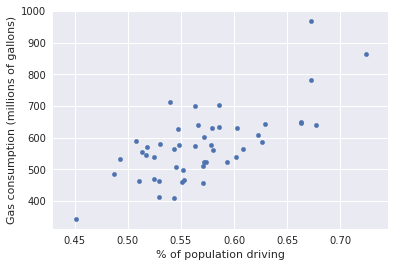

In [7]:
gas.plot(x='drivers', y='gas', kind='scatter')
plt.xlabel('% of population driving')
plt.ylabel('Gas consumption (millions of gallons)');

We could try to draw a line describing the trend in the data, but which is the best one?

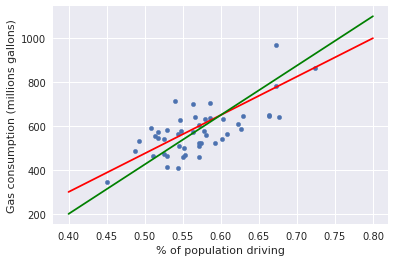

In [8]:
gas.plot(x='drivers', y='gas', kind='scatter')
plt.xlabel('% of population driving')
plt.ylabel('Gas consumption (millions gallons)')

plt.plot([.4, .8], [300, 1000], 'r-')
plt.plot([.4, .8], [200, 1100], 'g-');

In order to compare the different trend lines we need to define a **metric** for how well they describe the actual data. The metric should reflect what we value about our trend line. We want our trend line to reliably predict a y-value given an x-value, so it would be reasonable to construct our metric based on the **error** between the trend line and the y-values.

$$ e_i = y_i - (\beta_0 + \beta_1x_i) $$

We want to make the total error as small as possible. Since sometimes the errors will be positive and some will be negative, if we add them together they might cancel out. We don't care if the error is positive or negative, we want the _absolute value_ to be small. Instead of minimizing the total error, we'll minimize the total squared error. Often we divide it by the number of data points, $n$, which is called the **mean squared error** (MSE).

$$ MSE = \frac{1}{n}\sum_i e_i^2 $$

Since $e_i$ depends on our model parameters $\beta_0$ and $\beta_1$, we can tweak our model (the trend line) until the MSE is minimized. In the language of machine learning, the MSE would be called the **cost function** or **loss function**. For different machine learning tasks, we will define different cost functions (or **objective functions/utility functions**, which we seek to maximize instead of minimize).

(50, 1)


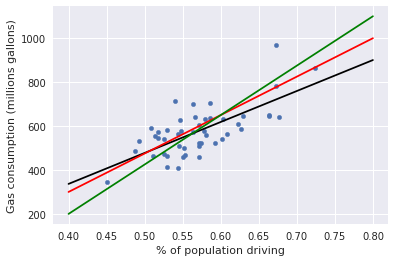

In [9]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression(fit_intercept=True)
linreg.fit(gas[['drivers']], gas['gas'])

gas.plot(x='drivers', y='gas', kind='scatter')
plt.xlabel('% of population driving')
plt.ylabel('Gas consumption (millions gallons)')

x = np.linspace(.4, .8).reshape(-1, 1)
print(x.shape)
plt.plot(x, linreg.predict(x), 'k-')
plt.plot([.4, .8], [300, 1000], 'r-')
plt.plot([.4, .8], [200, 1100], 'g-');

In [10]:
(linreg.intercept_, linreg.coef_[0])

(-227.3091174945256, 1409.8421113288002)

## Gradient descent

How did we find the model parameters that minimize the cost function? Let's plot the cost function with respect to $\beta_1$ to get an idea.

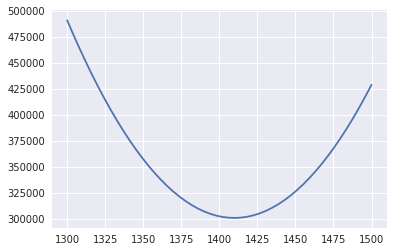

In [11]:
beta0 = linreg.intercept_
beta1 = np.linspace(1300, 1500)

MSE = [((gas['gas'] - (beta0 + m * gas['drivers']))**2).sum() for m in beta1]

plt.plot(beta1, MSE);

If we started with some initial guess $\beta_1 = 1300$, we could simply follow the slope of the MSE downhill with respect to $\beta_1$. We could calculate the MSE around 1300 to work out which way is downhill, and then update $\beta_1$ in that direction. With each step we move closer and closer to the bottom of the valley at 1409.

This method of always going downhill from where we are is called **gradient descent**. In general the loss function could be very complicated and we won't be able to solve where the minimum is directly. Gradient descent gives us an algorithm for finding our way to the minimum when we don't know where it is in advance.

For example, the `HuberRegressor` also optimizes a linear model, but [uses a more complicated loss function](http://scikit-learn.org/stable/modules/linear_model.html#huber-regression). The Huber loss is less influenced by outliers than the MSE.

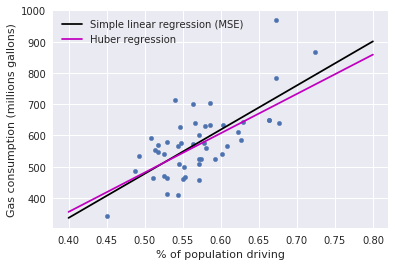

In [10]:
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor(fit_intercept=True, alpha=0)
huber.fit(gas[['drivers']], gas['gas'])
gas.plot(x='drivers', y='gas', kind='scatter')
plt.xlabel('% of population driving')
plt.ylabel('Gas consumption (millions gallons)')

x = np.linspace(.4, .8).reshape(-1, 1)
plt.plot(x, linreg.predict(x), 'k-')
plt.plot(x, huber.predict(x), 'm-')
plt.legend(['Simple linear regression (MSE)', 'Huber regression']);

## Multivariate regression

Looking again at our DataFrame, we see we have other variables we could use to predict gas consumption.

In [12]:
from ipywidgets import widgets

feature_desc = {'tax': 'Gas tax', 'drivers': '% of population driving', 'income': 'Average income (USD)', 'highway': 'Miles of paved highway'}
def plot_feature(column):
    plt.plot(gas[column], gas['gas'], '.')
    plt.xlabel(feature_desc[column])
    plt.ylabel('Gas consumption (millions gallons)')

dropdown_menu = {v: k for k, v in feature_desc.items()}

widgets.interact(plot_feature, column=dropdown_menu);

interactive(children=(Dropdown(description='column', options={'Gas tax': 'tax', '% of population driving': 'dr…

In [13]:
dropdown_menu

{'Gas tax': 'tax',
 '% of population driving': 'drivers',
 'Average income (USD)': 'income',
 'Miles of paved highway': 'highway'}

To use all of these predictors (called **features**), we will need to fit a slightly more complicated function

$$ y_i \approx \beta_0 + \beta_1x_{1i} + \beta_2x_{2i} + \beta_3x_{3i} + \beta_4x_{4i} $$

or more generally

$$ y_i \approx  \sum_j\beta_jX_{ij} $$

where $i$ labels different **observations** and $j$ labels different **features**. When we have one feature, we solve for a line; when we have two features, we solve for a plane; and so on, even if we can't imagine higher dimensional spaces.

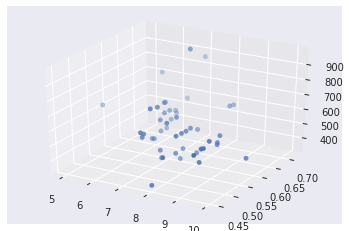

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt3d = plt.figure().gca(projection='3d')
plt3d.scatter(gas['tax'], gas['drivers'], gas['gas']);

In [15]:
linreg.fit(gas[['tax', 'drivers']], gas['gas'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

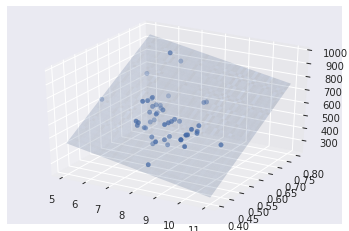

In [16]:
plt3d = plt.figure().gca(projection='3d')

xx, yy = np.meshgrid(np.linspace(5, 11), np.linspace(.4, .8))
z = linreg.intercept_ + linreg.coef_[0] * xx + linreg.coef_[1] * yy
plt3d.plot_surface(xx, yy, z, alpha=0.2)
plt3d.scatter(gas['tax'], gas['drivers'], gas['gas']);

In [17]:
from ipywidgets import interact

def plot_cross(tax=5):
    x = np.linspace(.4, .8)
    plt.plot(x, linreg.intercept_ + linreg.coef_[0]*tax + linreg.coef_[1]*x)
    alpha = 1 - abs(gas['tax'] - tax) / abs(gas['tax'] - tax).max()
    colors = np.zeros((len(gas), 4))
    colors[:, 3] = alpha
    plt.scatter(gas['drivers'], gas['gas'], color=colors)

interact(plot_cross, tax=(5,11,1));

interactive(children=(IntSlider(value=5, description='tax', max=11, min=5), Output()), _dom_classes=('widget-i…

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = gas[['tax', 'income', 'highway', 'drivers']]
y = gas['gas']
pipe = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [19]:
pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'regressor': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)}

In [20]:
lr = pipe.named_steps['regressor']

In [21]:
lr.coef_

array([-32.7310515 , -37.79691223,  -8.3813148 ,  73.3569154 ])

*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*